# **Introduction**

# F1 2024 Driver Points Prediction using Machine Learning

In this notebook, we aim to predict the end-of-season total points for Formula 1 drivers in 2024 using historical performance data (2020–2023).
We’ll engineer features, train multiple models, evaluate their accuracy, and visualize results.


In [29]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle
!kaggle datasets download -d rohanrao/formula-1-world-championship-1950-2020

!unzip -q formula-1-world-championship-1950-2020.zip -d f1_data

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
License(s): CC0-1.0
formula-1-world-championship-1950-2020.zip: Skipping, found more recently modified local copy (use --force to force download)
replace f1_data/circuits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## **Import libraries**

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

In [31]:
# Max oszlop
pd.set_option('display.max_columns', None)

# Ne tördelje szét az oszlopokat
pd.set_option('display.expand_frame_repr', False)

## **Load Data**

In [32]:
circuits = pd.read_csv("f1_data/circuits.csv")
constructor_results = pd.read_csv("f1_data/constructor_results.csv")
constructor_standings = pd.read_csv("f1_data/constructor_standings.csv")
constructors = pd.read_csv("f1_data/constructors.csv")
driver_standings = pd.read_csv("f1_data/driver_standings.csv")
drivers = pd.read_csv("f1_data/drivers.csv")
lap_times = pd.read_csv("f1_data/lap_times.csv")
pit_stops = pd.read_csv("f1_data/pit_stops.csv")
qualifying = pd.read_csv("f1_data/qualifying.csv")
races = pd.read_csv("f1_data/races.csv")
results = pd.read_csv("f1_data/results.csv")
seasons = pd.read_csv("f1_data/seasons.csv")
sprint_results = pd.read_csv("f1_data/sprint_results.csv")
status = pd.read_csv("f1_data/status.csv")

## **Preprocessing**

In [33]:
results['points'] = pd.to_numeric(results['points'], errors='coerce').fillna(0)
results['position'] = pd.to_numeric(results['position'], errors='coerce')
results['position'] = results['position'].fillna(results['position'].median())
sprint_results['points'] = pd.to_numeric(sprint_results['points'], errors='coerce').fillna(0)

## **Feature engineering**

In [34]:
def create_driver_stats(results_df, race_ids, constructor_standings_df):
    driver_stats = results_df.groupby('driverId').agg({
        'points': ['mean', 'sum', lambda x: (x > 0).sum()],
        'position': ['mean', 'std'],
        'constructorId': ['nunique']
    }).reset_index()
    driver_stats.columns = ['driverId', 'avg_points', 'total_points', 'points_count', 'avg_position', 'position_std', 'constructor_count']

    constructor_stats = (
        constructor_standings_df[constructor_standings_df['raceId'].isin(race_ids)]
        .groupby('constructorId')['points']
        .sum()
        .reset_index()
        .rename(columns={'points': 'team_points'})
    )
    merged = results_df.merge(constructor_stats, on='constructorId', how='left')
    driver_stats = driver_stats.merge(
        merged[['driverId', 'team_points']].drop_duplicates(),
        on='driverId', how='left'
    )
    return driver_stats

In [35]:
features = ['total_points', 'points_count', 'avg_position', 'position_std', 'team_points']
years = [2020, 2021, 2022, 2023]
weights = {2020: 0.1, 2021: 0.2, 2022: 0.3, 2023: 0.4}
weighted_stats = None

for year in years:
    race_ids = races[races.year == year]['raceId'].values
    res_year = results[results.raceId.isin(race_ids)].copy()
    sprint_pts = (
        sprint_results[sprint_results.raceId.isin(race_ids)]
        .groupby('driverId')['points']
        .sum()
        .reset_index()
        .rename(columns={'points': 'sprint_points'})
    )

    stats = create_driver_stats(res_year, race_ids, constructor_standings)
    stats = stats.merge(sprint_pts, on='driverId', how='left').fillna({'sprint_points': 0})
    stats['total_points'] += stats['sprint_points']

    for col in features:
        stats[col] *= weights[year]
    stats = stats.groupby('driverId')[features].sum().reset_index()

    if weighted_stats is None:
        weighted_stats = stats.set_index('driverId')
    else:
        weighted_stats = weighted_stats.add(stats.set_index('driverId'), fill_value=0)

weighted_stats = weighted_stats.reset_index()

## **Prepare 2024 Target & Merge with Features**

In [36]:
race_ids_2024 = races[races.year == 2024]['raceId'].values
last_standings_2024 = (
    driver_standings[driver_standings.raceId.isin(race_ids_2024)]
    .groupby('driverId').last()
    .reset_index()[['driverId', 'points']]
    .rename(columns={'points': 'total_points_2024'})
)

data = last_standings_2024.merge(weighted_stats, on='driverId', how='left')
data = data.merge(drivers[['driverId', 'surname']], on='driverId', how='left')

for col in features:
    data[col] = data[col].fillna(0)

## **Correlation Analysis**

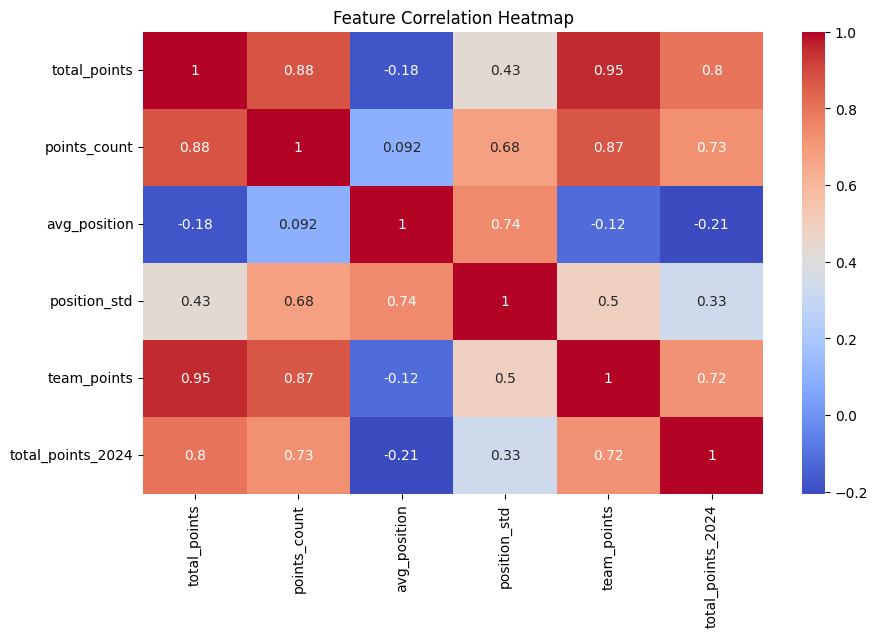

In [37]:
plt.figure(figsize=(10,6))
sns.heatmap(data[features + ['total_points_2024']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## **Training & Test Setup**

In [38]:
X_train = weighted_stats[features]
y_train = weighted_stats['total_points']
X_test = data[features]
y_test = data['total_points_2024']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Utility Functions**

In [39]:
def evaluate_model(y_true, y_pred, label=""):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    print()
    print(f"----- {label} -----")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R2: {r2:.3f}")
    print(f"Spearman: {spearman_corr:.3f}\n")

def normalize_predictions(y_pred, target_total):
    scale = target_total / y_pred.sum() if y_pred.sum() > 0 else 0
    return y_pred * scale

def summarize_predictions(model_name, y_pred, y_pred_norm, y_true, data_ref):
    df = pd.DataFrame({
        'surname': data_ref['surname'],
        'true_points_2024': y_true,
        f'{model_name}_pred_raw': y_pred,
        f'{model_name}_pred_normalized': y_pred_norm
    })
    df = df.sort_values(by='true_points_2024', ascending=False)
    print(f"\n----- Predikciók és valós értékek ({model_name}) -----")
    print(df[['surname', f'{model_name}_pred_raw', f'{model_name}_pred_normalized', 'true_points_2024']].to_string(index=False))

def plot_predictions(model_name, y_true, y_pred_raw, y_pred_norm):
    print()
    print()
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred_raw, label='Raw pred', alpha=0.7, marker='o')
    plt.scatter(y_true, y_pred_norm, label='Normalized pred', alpha=0.7, marker='x')
    max_val = max(max(y_true), max(y_pred_raw), max(y_pred_norm))
    plt.plot([0, max_val], [0, max_val], 'k--', label='Perfect prediction')
    plt.xlabel("True Points (2024)")
    plt.ylabel("Predicted Points")
    plt.title(f"{model_name} – Predicted vs Actual")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Train & Evaluate Models**

In [40]:
real_total_points_2024 = y_test.sum()
print(f"Valós kiosztott pontok összege 2024-ben: {real_total_points_2024:.1f}")

Valós kiosztott pontok összege 2024-ben: 2659.0


### Random Forest

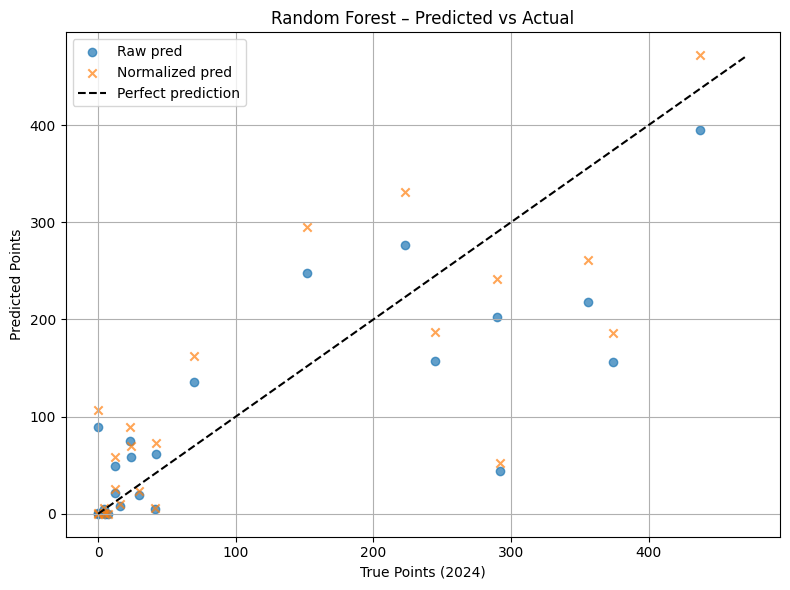


----- Random Forest (raw) -----
MSE: 7370.622
MAE: 56.217
R2: 0.629
Spearman: 0.773


----- Random Forest (normalized) -----
MSE: 7163.098
MAE: 57.609
R2: 0.639
Spearman: 0.773


----- Predikciók és valós értékek (RandomForest) -----
   surname  RandomForest_pred_raw  RandomForest_pred_normalized  true_points_2024
Verstappen                394.899                    471.793328             437.0
    Norris                155.827                    186.169474             374.0
   Leclerc                218.377                    260.899145             356.0
   Piastri                 43.916                     52.467278             292.0
     Sainz                202.169                    241.535140             290.0
   Russell                156.940                    187.499196             245.0
  Hamilton                276.791                    330.687459             223.0
     Pérez                247.296                    295.449223             152.0
    Alonso                1

In [41]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)
y_pred_rf = model_rf.predict(X_test_scaled)
y_pred_rf_norm = normalize_predictions(y_pred_rf, real_total_points_2024)

plot_predictions("Random Forest", y_test, y_pred_rf, y_pred_rf_norm)
evaluate_model(y_test, y_pred_rf, "Random Forest (raw)")
evaluate_model(y_test, y_pred_rf_norm, "Random Forest (normalized)")
summarize_predictions("RandomForest", y_pred_rf, y_pred_rf_norm, y_test.values, data)

### XGBoost

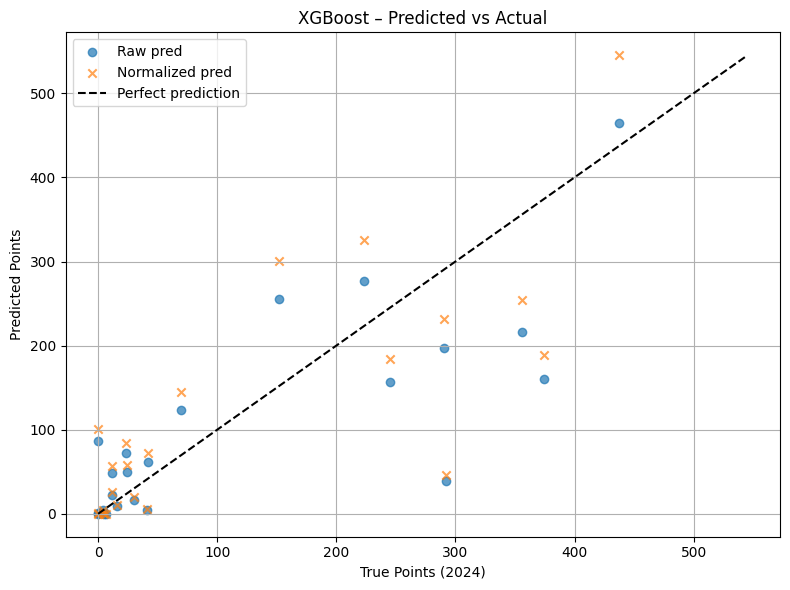


----- XGBoost (raw) -----
MSE: 7370.508
MAE: 55.212
R2: 0.629
Spearman: 0.776


----- XGBoost (normalized) -----
MSE: 7596.119
MAE: 60.042
R2: 0.617
Spearman: 0.776


----- Predikciók és valós értékek (XGBoost) -----
   surname  XGBoost_pred_raw  XGBoost_pred_normalized  true_points_2024
Verstappen        464.213226               545.261762             437.0
    Norris        160.281433               188.265503             374.0
   Leclerc        216.297668               254.061800             356.0
   Piastri         38.799313                45.573414             292.0
     Sainz        197.134186               231.552501             290.0
   Russell        156.288620               183.575571             245.0
  Hamilton        277.188416               325.583665             223.0
     Pérez        255.592224               300.216923             152.0
    Alonso        122.890991               144.346939              70.0
     Gasly         61.199486                71.884508         

In [42]:
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)
y_pred_xgb_norm = normalize_predictions(y_pred_xgb, real_total_points_2024)

plot_predictions("XGBoost", y_test, y_pred_xgb, y_pred_xgb_norm)
evaluate_model(y_test, y_pred_xgb, "XGBoost (raw)")
evaluate_model(y_test, y_pred_xgb_norm, "XGBoost (normalized)")
summarize_predictions("XGBoost", y_pred_xgb, y_pred_xgb_norm, y_test.values, data)

### Ridge Regression

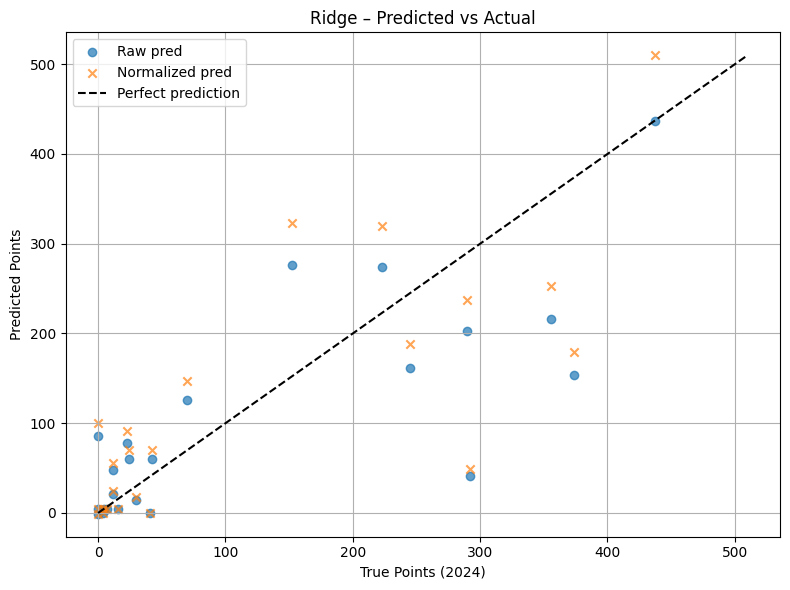


----- Ridge (raw) -----
MSE: 7581.902
MAE: 55.593
R2: 0.618
Spearman: 0.726


----- Ridge (normalized) -----
MSE: 7719.845
MAE: 60.208
R2: 0.611
Spearman: 0.726


----- Predikciók és valós értékek (Ridge) -----
   surname  Ridge_pred_raw  Ridge_pred_normalized  true_points_2024
Verstappen      436.218231             510.024952             437.0
    Norris      153.684944             179.687942             374.0
   Leclerc      216.186954             252.765091             356.0
   Piastri       41.625551              48.668460             292.0
     Sainz      202.899547             237.229498             290.0
   Russell      161.502818             188.828575             245.0
  Hamilton      273.738608             320.054299             223.0
     Pérez      276.159049             322.884272             152.0
    Alonso      125.789270             147.072409              70.0
     Gasly       59.865310              69.994328              42.0
Hülkenberg       -0.304977              

In [43]:
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_scaled, y_train)
y_pred_ridge = model_ridge.predict(X_test_scaled)
y_pred_ridge_norm = normalize_predictions(y_pred_ridge, real_total_points_2024)

plot_predictions("Ridge", y_test, y_pred_ridge, y_pred_ridge_norm)
evaluate_model(y_test, y_pred_ridge, "Ridge (raw)")
evaluate_model(y_test, y_pred_ridge_norm, "Ridge (normalized)")
summarize_predictions("Ridge", y_pred_ridge, y_pred_ridge_norm, y_test.values, data)

In [44]:
# Mentés fájlba
joblib.dump(model_rf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [45]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import joblib
import numpy as np

# Modell betöltése
model = joblib.load("random_forest_model.pkl")

# Versenyzők és jellemzőik
driver_names = [
    "Hamilton", "Alonso", "Hülkenberg", "Pérez", "Ricciardo", "Bottas",
    "Magnussen", "Verstappen", "Sainz", "Ocon", "Stroll", "Gasly", "Leclerc",
    "Norris", "Russell", "Albon", "Tsunoda", "Zhou", "Piastri", "Sargeant",
    "Lawson", "Bearman", "Colapinto", "Doohan"
]

driver_features = [
    [277.8, 19.3, 4.510227272727272, 2.934496037282644, 5576.3],
    [122.9, 14.8, 6.668181818181818, 3.025237458351052, 2407.5],
    [4.6, 0.6000000000000001, 10.716666666666667, 2.3088332933273357, 394.0],
    [256.0, 17.8, 5.2281818181818185, 3.865689952387723, 8115.9],
    [48.4, 6.5, 10.727158135981664, 3.308427682734087, 1481.6],
    [86.2, 8.7, 9.575668449197861, 3.7332074238839112, 2299.5],
    [8.8, 3.1, 10.358021390374333, 3.1318918307600323, 255.1],
    [466.7, 19.8, 2.364973262032086, 2.4645375755656693, 8238.9],
    [197.2, 17.2, 6.0, 2.9389624857580694, 4601.3],
    [71.8, 13.4, 8.659893048128342, 2.775851816121701, 1536.5],
    [49.3, 10.0, 9.79034090909091, 3.029448726678561, 2050.4],
    [61.2, 10.2, 9.759893048128342, 3.253463853199407, 1063.4],
    [216.4, 16.7, 5.4917112299465245, 2.786619093023865, 4556.8],
    [160.3, 16.8, 7.445989304812834, 4.051000636051318, 2453.2],
    [156.3, 13.8, 9.011764705882353, 3.758957021572792, 4244.4],
    [22.5, 4.9, 8.55179526355997, 2.341449943062, 430.6],
    [16.8, 5.0, 10.568181818181818, 3.1338059590382903, 507.1],
    [4.2, 2.1, 8.604545454545455, 2.0837944894022997, 368.8],
    [38.8, 4.4, 3.7636363636363637, 1.7134052573041718, 996.4],
    [0.4, 0.4, 5.363636363636363, 1.5936019263188346, 117.2],
    [0.8, 0.4, 4.88, 1.2132600710482482, 53.6],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0]
]

# Widgetek
driver_dropdown = widgets.Dropdown(
    options=driver_names,
    value="Hamilton",
    description='Driver:'
)
predict_btn = widgets.Button(description='Predict', button_style='success')
output = widgets.Output()

# Predikció logika
def predict_points(event):
    output.clear_output()
    name = driver_dropdown.value
    idx = driver_names.index(name)
    features = np.array(driver_features[idx]).reshape(1, -1)

    pred = model.predict(features)

    with output:
        print(f"Prediction for {name}:")
        print(f"Points: {pred[0]}")

predict_btn.on_click(predict_points)

# Megjelenítés
display(widgets.VBox([driver_dropdown, predict_btn, output]))
